# Importing Libraries

In [76]:
import pandas as pd
import numpy as np
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning

In [77]:
def safe_convert(col):
    col_cleaned = col.replace(',', '', regex=True)
    return pd.to_numeric(col_cleaned, errors='coerce')

setpt = pd.read_csv('setpoint_publish(in).csv')
setpt = setpt.apply(lambda col: safe_convert(col) if col.name != 'var' else col)
setpt

,var,opt_mean,opt_sig,drift_mean,drift_sig,excursion_mean,excursion_sig
0,x1,22.1,0.295,22.111,0.442,22.115,0.5900
1,x2,44.8,1.045,46.010,1.840,46.547,2.3270
2,x4,0.4,0.023,0.368,0.027,0.304,0.0670
3,x5,150000.0,8000.000,135000.000,9000.000,120000.000,16000.0000
4,x7,1206.0,48.240,1266.300,75.978,1266.300,88.6410
5,x8,87.0,5.220,91.176,6.686,107.880,12.2264
6,x9,454.0,19.673,456.270,22.814,599.280,69.9160
7,x17,5492.0,256.293,5526.050,349.983,5552.410,425.6850
8,x3,NaN,NaN,39.000,2.860,NaN,NaN
9,x6,NaN,NaN,112.000,6.720,NaN,NaN


# Generating the dataset

In [78]:
def generate_normal_data(mean, std_dev, size=5000, seed=42):
    #np.random.seed(seed)
    return np.random.normal(loc=mean, scale=std_dev, size=size)

def generate_skewed_normal_data(mean, std_dev, skew, size=5000, seed=42):
    #np.random.seed(seed)
    return skewnorm.rvs(skew, loc=mean, scale=std_dev, size=size)

In [79]:
datasets = {} # dict to store the generated number
skew_variables = {
    "x4": 200,
    "x5": 200,
    "x8": -100,
    "x9": -200
}

for data_name in ["drift", "excursion"]:
    rows = []
    for var, mean, sig in zip(setpt['var'], setpt[f'{data_name}_mean'], setpt[f'{data_name}_sig']):
        if data_name == "excursion" and var in skew_variables:
            # Generate skewed data for the specified variables (x4, x5, x8, x9)
            skew = skew_variables[var]
            rows.append(generate_skewed_normal_data(mean=mean, std_dev=sig, skew=skew, size=5000, seed=42))
        else:
            # Generate normal data for other variables
            rows.append(generate_normal_data(mean=mean, std_dev=sig, size=5000, seed=42))

    # Assign the generated data to the dataset
    datasets[data_name] = pd.DataFrame(np.column_stack(rows), columns=setpt['var'])

In [80]:
#opt_data = datasets['opt']
drift_data = datasets['drift']
exc_data = datasets['excursion']

# drop unnecessary columns
#opt_data.drop(columns=[' x3 ', ' x6 ', ' x10 ', ' x11 ', ' x12 ', ' x13 ', ' x14 ', ' x15 ', ' x16 ', ' x18 ', ' x19 '], axis = 1, inplace=True)
exc_data.drop(columns=[' x3 ', ' x6 ', ' x10 ', ' x11 ', ' x12 ', ' x13 ', ' x14 ', ' x15 ', ' x16 ', ' x18 ', ' x19 '], axis = 1, inplace=True)

# Outcome 

In [81]:
#opt_data['outcome'] = (-( 5 * np.pi * 10**4 * opt_data['x1'] + 770 * (opt_data['x2'] ** 2) +
#    58 * opt_data['x5'] * opt_data['x4'] - 890 * opt_data['x17'] + 730.5 * opt_data['x7'] ) / (8 * 10**5) + 7.5)


drift_data['outcome'] = (-( 5 * np.pi * 10**4 * drift_data['x1'] + 770 * (drift_data['x2'] ** 2) +
    58 * drift_data['x5'] * drift_data['x4'] - 890 * drift_data['x17'] + 730.5 * drift_data['x7'] ) / (8 * 10**5) 
    + (39 * drift_data['x5'] * drift_data['x9'] * drift_data['x8']) / (10**11) + 7)

exc_data['outcome'] = (-( 5 * np.pi * 10**4 * exc_data['x1'] + 770 * (exc_data['x2'] ** 2) +
    58 * exc_data['x5'] * exc_data['x4'] - 890 * exc_data['x17'] + 730.5 * exc_data['x7'] ) / (8 * 10**5) 
    + (39 * exc_data['x5'] * exc_data['x9'] * exc_data['x8']) / (10**11) + 7 
    + ((0.8 * exc_data['x4'] * (exc_data['x5'])**2 * exc_data['x17'] ) / (10**13)))


In [82]:
drift_data

var,x1,x2,x4,x5,x7,x8,x9,x17,x3,x6,x10,x11,x12,x13,x14,x15,x16,x18,x19,outcome
0,22.780558,43.705158,0.368876,121922.732487,1385.955687,93.024751,450.262165,5720.126727,36.989352,111.052195,560.161888,7.798555,15503.134223,357.536063,7808.615418,29.167310,665.297644,111184.039679,6396.906067,4.517638
1,21.569469,44.599345,0.346992,135983.426714,1194.062497,98.154152,463.894205,6139.822447,42.092148,111.090577,542.009365,8.204401,13109.911838,331.315315,9204.169802,25.129055,641.913610,126232.845687,6601.136806,5.584419
2,23.203345,46.169765,0.335544,139371.905910,1186.764858,91.201962,476.599667,5368.044014,37.919428,112.509900,531.383323,7.884472,15929.824293,340.163804,7035.570358,29.150190,656.790282,121066.909417,6426.872472,4.252761
3,21.389617,45.872145,0.386834,139755.249551,1262.771995,84.234564,438.219964,5988.234459,40.772230,113.293994,566.896450,8.601754,15007.422237,334.919696,8358.612132,27.492552,655.588909,119811.314435,5780.125141,4.376101
4,22.541639,46.862372,0.378250,142941.299410,1226.814920,99.039988,489.951671,4830.636831,43.472932,127.165112,555.839507,7.969416,15417.270149,362.649622,8378.854961,29.479489,659.640566,127930.754034,7354.429223,3.499299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,23.366617,44.796879,0.394306,126484.851233,1408.367471,89.265552,425.725445,5442.982062,36.827836,111.362019,562.360605,7.819778,14864.013579,314.288409,7686.527927,26.546795,634.660655,131002.715066,5985.716923,3.508562
4996,21.251548,46.989940,0.336320,132907.011038,1289.128906,95.361125,489.677125,5915.764746,41.490246,112.377796,555.349790,8.000794,12919.486517,299.412277,7892.559045,27.307331,629.738782,117506.117889,6755.906470,5.285910
4997,22.192893,44.707554,0.344509,134691.280666,1214.254590,91.118180,459.425874,6152.864560,36.399319,111.054821,542.913762,7.661512,13965.882470,346.115756,8432.492301,24.831676,629.889780,122000.215705,6134.117412,5.289742
4998,21.938618,48.933320,0.380520,134210.600517,1262.847499,85.963524,423.680010,5600.703773,40.517606,105.950475,551.898222,7.872440,15771.271182,334.295519,8739.511334,28.173733,622.319350,127322.204494,6451.113099,3.669122


In [83]:
exc_data

var,x1,x2,x4,x5,x7,x8,x9,x17,outcome
0,22.455003,49.925110,0.382021,125344.705074,1261.830727,107.116154,587.333583,5607.061060,7.573726
1,23.311976,40.625194,0.307285,122603.104713,1248.156478,107.747509,585.042285,5737.890587,8.480865
2,22.413624,45.366269,0.335810,126706.073458,1315.715120,91.621452,537.765595,5076.221730,6.603352
3,21.257167,46.238438,0.360972,121617.903679,1147.802428,106.498565,498.940901,6066.829020,8.398440
4,21.643964,46.007530,0.403677,132972.657302,1424.103773,104.273123,512.157925,5539.175634,7.615666
...,...,...,...,...,...,...,...,...,...
4995,22.515056,48.324664,0.361294,137331.186130,1231.412245,97.587764,585.229678,6337.917424,9.174483
4996,22.187495,44.724435,0.305870,133336.275572,1433.209403,106.746501,538.983107,5701.791060,8.268303
4997,21.700800,45.641088,0.339376,151930.158093,1191.673737,95.361187,585.470733,4671.720433,7.340918
4998,20.745770,45.379447,0.316420,126451.037958,1244.991950,92.692260,569.015502,4635.396259,6.541020


In [84]:
#opt_data.to_csv("data/opt_data.csv", index=None)
drift_data.to_csv("data/drift_data.csv", index=None)
exc_data.to_csv("data/excursion_data.csv", index=None)

# Plotting

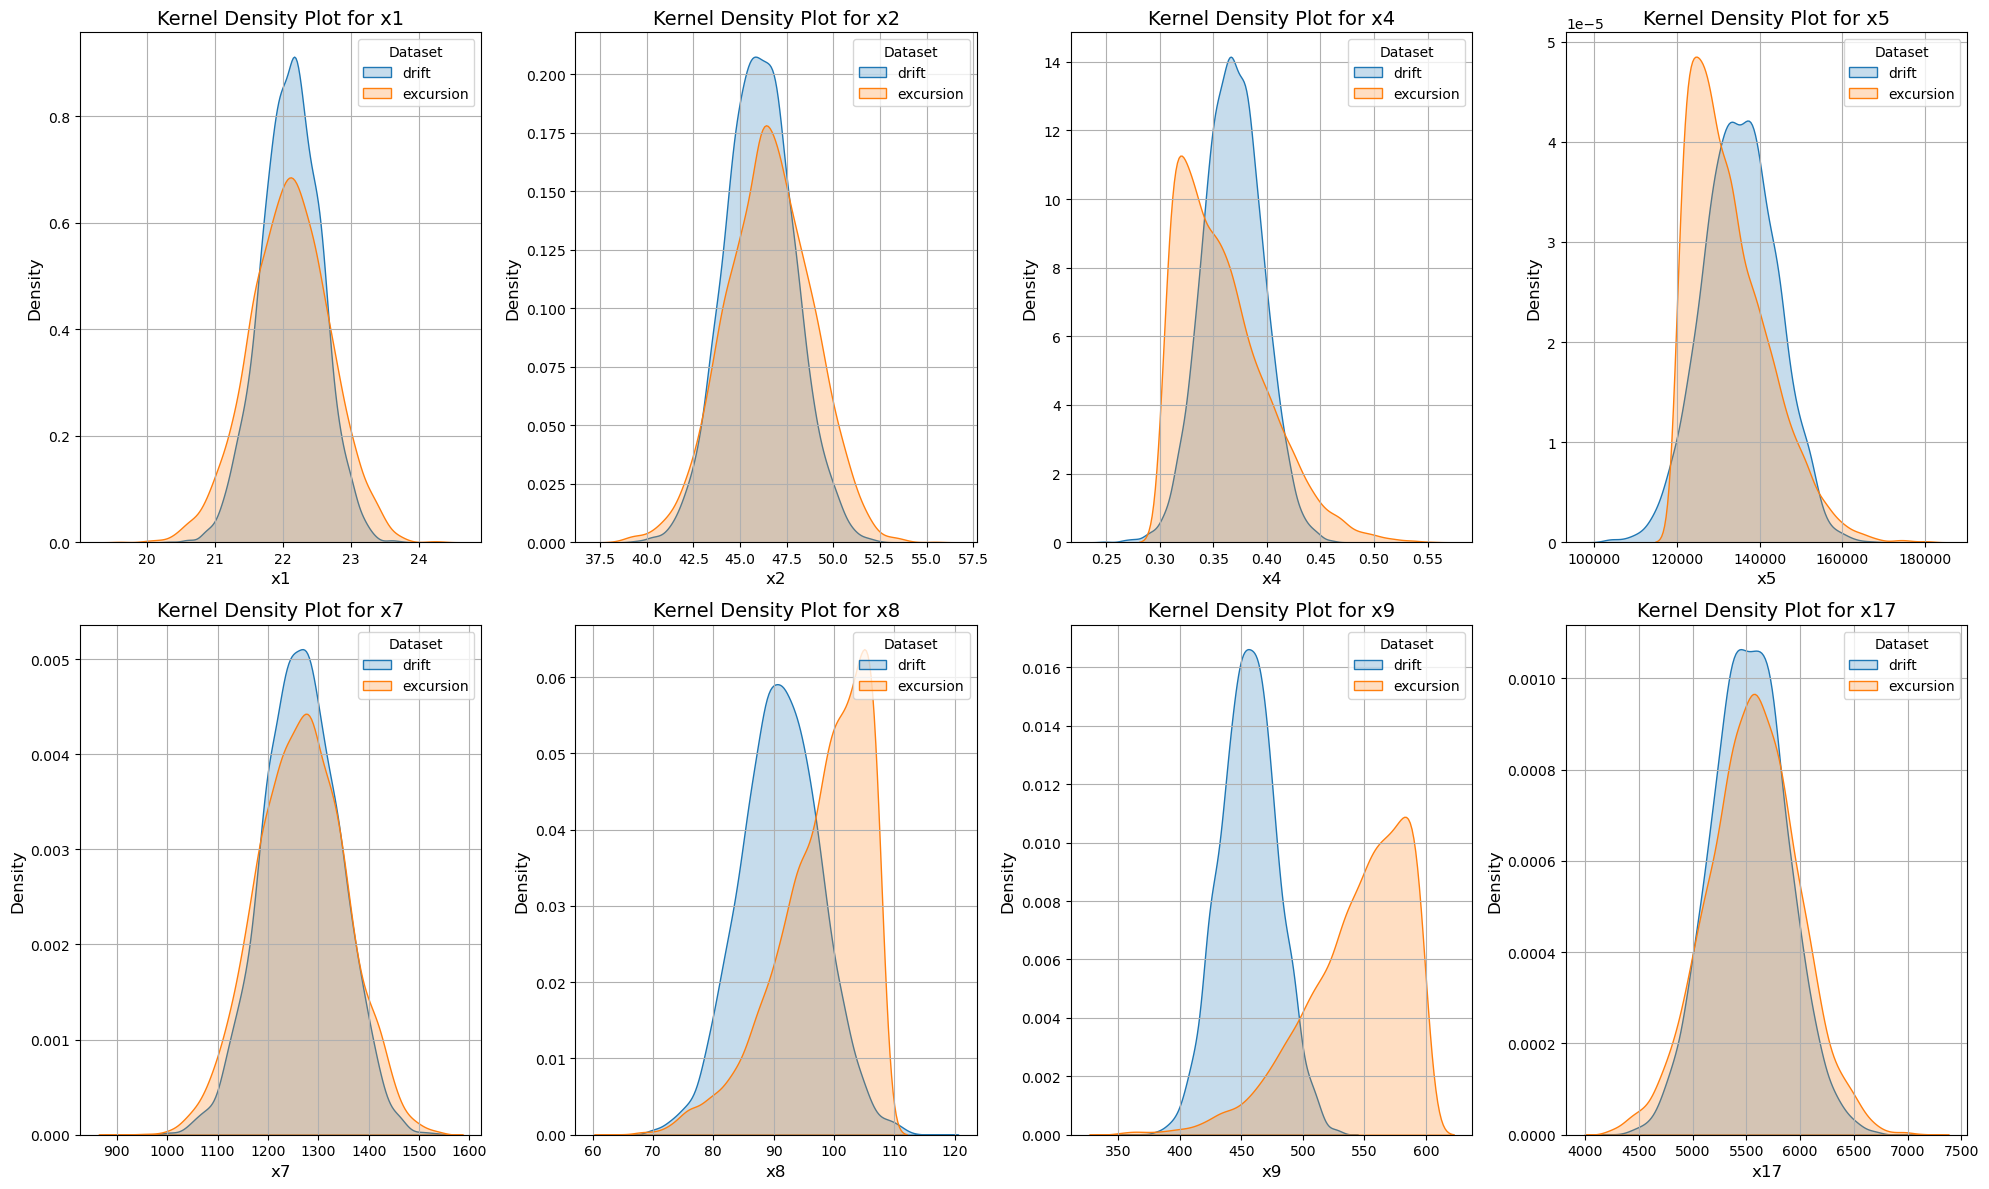

In [85]:
selected_variables = ['x1', 'x2', 'x4', 'x5', 'x7', 'x8', 'x9', 'x17']

plots_per_row = 4
num_variables = len(selected_variables)
num_rows = (num_variables + plots_per_row - 1) // plots_per_row 

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, 6 * num_rows))
axes = axes.flatten()  

# Generate the plots for the selected variables
for i, variable in enumerate(selected_variables):
    ax = axes[i]
    for name, df in datasets.items():
        sns.kdeplot(df[variable], label=name, fill=True, ax=ax)
    ax.set_title(f'Kernel Density Plot for {variable}', fontsize=14)
    ax.set_xlabel(variable, fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend(title='Dataset')
    ax.grid(True)

# Remove excess subplots if needed
for j in range(len(selected_variables), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

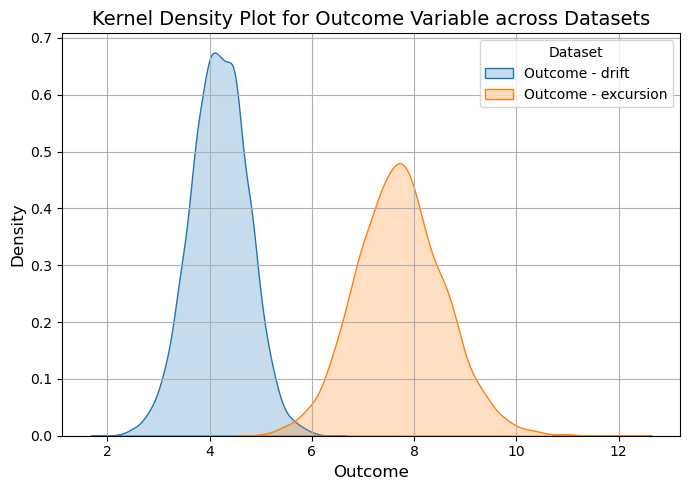

In [86]:
plt.figure(figsize=(7, 5))

# Loop over the datasets and plot the KDE for the 'outcome' variable in each
for name, df in datasets.items():
    sns.kdeplot(df['outcome'], label=f'Outcome - {name}', fill=True)

# Add labels and title
plt.title('Kernel Density Plot for Outcome Variable across Datasets', fontsize=14)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Dataset')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

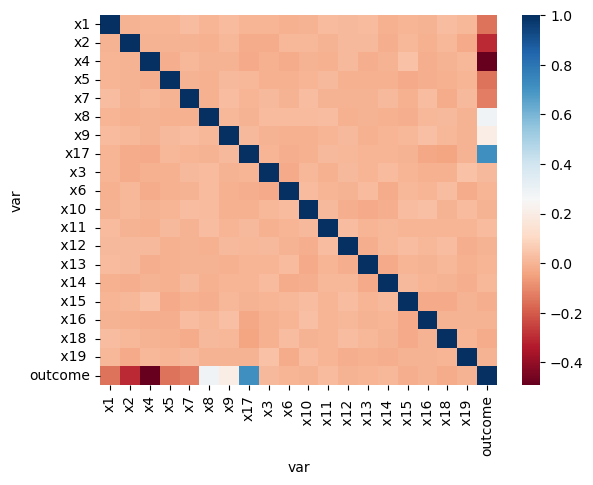

In [87]:
corr = drift_data.corr()

sns.heatmap(corr, 
            cmap='RdBu', 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

C:\Users\hrith\AppData\Local\Temp\ipykernel_2160\2079452644.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  interaction_table_binned = drift_data_cleaned.pivot_table(


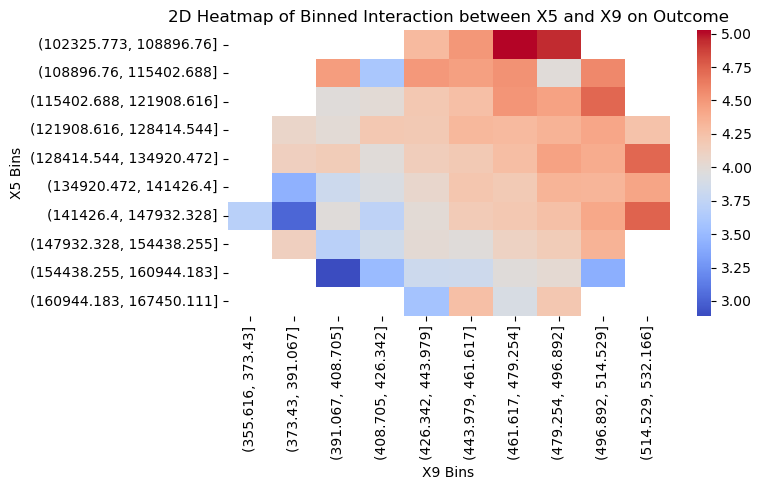

In [88]:
drift_data_cleaned = drift_data.dropna(subset=['x5', 'x9', 'outcome'])

drift_data_cleaned['x5_bins'] = pd.cut(drift_data_cleaned['x5'], bins=10)
drift_data_cleaned['x9_bins'] = pd.cut(drift_data_cleaned['x9'], bins=10)

# Create a pivot table with the binned values
interaction_table_binned = drift_data_cleaned.pivot_table(
    values='outcome', 
    index='x5_bins', 
    columns='x9_bins', 
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(interaction_table_binned, cmap="coolwarm", annot=False)
plt.title("2D Heatmap of Binned Interaction between X5 and X9 on Outcome")
plt.xlabel("X9 Bins")
plt.ylabel("X5 Bins")
plt.tight_layout()
plt.show()